In [16]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from tensorflow.keras.preprocessing.image import load_img , img_to_array
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import VGG19


In [17]:
content_path =r"path to conetnt.JPG"
style_path =r"path to style.jpg"


In [18]:
tf.enable_eager_execution()

In [19]:
#aquiring the model
base_model= VGG19(weights='imagenet',include_top=False,pooling='max')
base_model.trainable = False

lrnRate = 0.1

In [20]:
def imgshow(image):
    image[:,:,0]  *=64/255.0
    image[:,:,1] *=128/255.0
    image[:,:,2] *=192/255.0
    image = image[:,:,::-1]
    image = np.clip(image,0,255).astype('uint8')
    img=np.squeeze(image)
    plt.imshow(img)
    print(img.shape)
    path = r'C:\Users\SHYAM A\Desktop'
    cv2.imwrite(os.path.join(path ,"Art"+'.jpg'),img)

In [21]:
def get_image(imgpath):
    w=512
    h=512
    loaded_img = load_img(imgpath,target_size=(w,h))
   
    image = preprocess_input(img_to_array(loaded_img))
    image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    image = np.expand_dims(image , axis = 0)
    return image


In [22]:
content_img = get_image(content_path)
style_img = get_image(style_path)

(512, 512, 3)


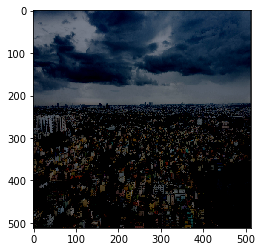

In [23]:
imgshow(content_img)

(512, 512, 3)


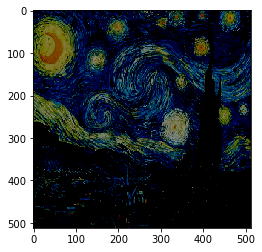

In [24]:
imgshow(style_img )

In [25]:
content_layers=["block5_conv2"]

style_layers=["block1_conv1",
              "block2_conv1",
              "block3_conv1",
              "block4_conv1",
              "block5_conv1",]
num_content=len(content_layers)
num_style=len(style_layers)


In [26]:
#our custom model with required content layers and output
content_model = Model(inputs=base_model.input,
                      outputs=base_model.get_layer(content_layers[0]).output )


In [27]:
#our custom model with required style layers and output
style_model =[Model(inputs=base_model.input,
                      outputs=base_model.get_layer(layer).output) for layer in style_layers]

lrnRate = 1/len(style_model) 

In [28]:
def Gram_Matrix(input_tensor):
    channels=int(input_tensor.shape[-1])
    a=tf.reshape(input_tensor,[-1,channels])
    n=tf.shape(a)[0]
    gram=tf.matmul(a,a,transpose_a=True)
    return(gram/tf.cast(n,tf.float32))

In [29]:
def Content_Cost(content,generated):
    actv_content = content_model(content)
    actv_generated = content_model(generated)
    cost = tf.reduce_mean(tf.square(actv_content - actv_generated))
    return(cost)

In [30]:
def Style_Cost(style,generated):
    style_cost = 0
    for style_models in style_model:
        Style = style_models(style)
        Generated = style_models(generated)
        cost= tf.reduce_mean(tf.square(Gram_Matrix(Style)-Gram_Matrix(Generated)))
        style_cost+=cost*lrnRate
        
    return(style_cost)
        

In [31]:
def run_style_transfer(content,style,iter=40,alpha=50. , beta=70.):
    init_content = content
    init_style = style
    content_generated=tf.contrib.eager.Variable(content,dtype = tf.float32)

    # Create our optimizer
    optimizer = tf.train.AdamOptimizer(learning_rate=7.)
    
    top_cost = 1e12 + 0.1
    top_img = None 
    
    for i in range(iter):
        with tf.GradientTape() as tape:
            cc = Content_Cost(init_content,content_generated) #content cost
            sc = Style_Cost(init_style,content_generated) #style cost
            
            cost=alpha*cc + beta*sc
            
        gradients = tape.gradient(cost ,content_generated)
        optimizer.apply_gradients([(gradients , content_generated)]) 
        
        if(cost<top_cost):
            top_cost=cost
            top_img = content_generated.numpy()
            
    return(top_cost,top_img)

In [32]:
top_cost, img = run_style_transfer(content_img,style_img)


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



(512, 512, 3)


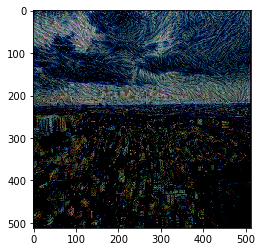

In [33]:
imgshow(img)